<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/04_Intro_to_Time_Series_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Ignacio Oguiza - email: timeseriesAI@gmail.com

## Purpose 😇

The purpose of this notebook is to show you how you can create a simple, end-to-end, state-of-the-art **time series regression** model using **`fastai`** and **`tsai`**.

A time series regression is a task in which you assign a continuous value to a univariate or multivariate time series. 

## Import libraries 📚

In [2]:
# ## NOTE: UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI
# stable = False # True: stable version in pip, False: latest version from github
# if stable: 
#     !pip install tsai -U >> /dev/null
# else:      
#     !pip install git+https://github.com/timeseriesAI/tsai.git -U >> /dev/null
# ## NOTE: REMEMBER TO RESTART (NOT RECONNECT/ RESET) THE KERNEL/ RUNTIME ONCE THE INSTALLATION IS FINISHED

In [1]:
import matplotlib.pyplot as plt
from tsai.all import *
computer_setup()

os             : Windows-10-10.0.18362-SP0
python         : 3.7.12
tsai           : 0.2.24
fastai         : 2.5.3
fastcore       : 1.3.27
torch          : 1.10.2+cpu
n_cpus         : 8
device         : cpu


## Prepare data 🔢

We are going to select a dataset from the recently released Monash, UEA & UCR 
Time Series Extrinsic Regression Repository (2020) ([web](http://tseregression.org), [paper](https://arxiv.org/abs/2006.10996)). 

Please, feel free to select any other dataset to experiment with it. Here's the entire list.

In [4]:
regression_list

['AppliancesEnergy',
 'AustraliaRainfall',
 'BeijingPM10Quality',
 'BeijingPM25Quality',
 'BenzeneConcentration',
 'Covid3Month',
 'FloodModeling1',
 'FloodModeling2',
 'FloodModeling3',
 'HouseholdPowerConsumption1',
 'HouseholdPowerConsumption2',
 'IEEEPPG',
 'LiveFuelMoistureContent',
 'NewsHeadlineSentiment',
 'NewsTitleSentiment']

In [3]:
dsid = 'AppliancesEnergy' 
type(dsid)

str

In [4]:
X, y, splits = get_regression_data(dsid, split_data=False)
type(X), type(y), type(splits)

(numpy.memmap, numpy.memmap, tuple)

In [5]:
X.shape, y.shape, splits

((137, 24, 144),
 (137,),
 ((#95) [0,1,2,3,4,5,6,7,8,9...],
  (#42) [95,96,97,98,99,100,101,102,103,104...]))

For regression tasks, we need to ensure y is a float. Let's check the format of the data:

X      - shape: [137 samples x 24 features x 144 timesteps]  type: memmap  dtype:float64  isnan: 0
y      - shape: (137,)  type: memmap  dtype:float64  isnan: 0
splits - n_splits: 2 shape: [95, 42]  overlap: False


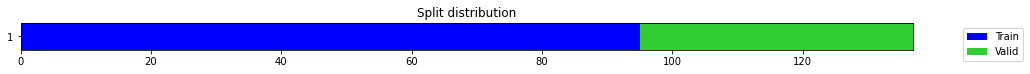

In [33]:
check_data(X, y, splits)

In [7]:
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=128)
dls.one_batch()

(TSTensor(samples:95, vars:24, len:144, device=cpu),
 tensor([19.3800, 12.6800,  5.3400, 12.7200, 13.2500, 26.2800, 13.1000, 14.0600,
         10.9200, 10.4600, 20.7400, 21.3100, 21.4900, 10.2500, 11.4000, 10.8000,
         11.6400, 23.4200, 11.2300, 13.5600, 14.8200, 16.5300, 19.9400, 12.7800,
         11.4900,  9.6300, 11.5300, 12.9700, 23.0100, 11.8300, 13.3700, 12.2400,
         14.8000, 19.0100, 12.9800, 12.0700, 10.6100, 17.3000,  8.6200,  9.6000,
         10.2600,  9.8200, 14.6100,  5.3800, 14.6200, 19.6200, 19.2200, 16.2500,
         16.2200,  9.1700, 15.8900, 10.8200, 18.1800, 12.0300, 11.5400, 13.2100,
         10.5100,  7.0300, 11.6300, 16.4100, 21.6900, 21.9100, 21.7400, 17.0000,
         22.1000, 12.6800, 10.5100, 14.9900, 10.3100, 12.5400, 16.0500, 18.5600,
         16.7700, 11.3200, 15.6800, 16.0200, 11.9300, 20.4400, 10.8900, 22.7400,
         10.6200, 11.9200, 17.5300, 10.1700, 11.0600, 10.6300,  9.9900, 10.1100,
         13.2900, 14.2800, 14.7100, 13.6900, 13.8700, 17

`TSDatasets` identifies this as a regression problem, as the 2nd output (the ys) are floats. That's why the number of classes is set to 1. This is required to be able to correctly use the time series models available in `timesereisAI`.

In [34]:
dls.c

1

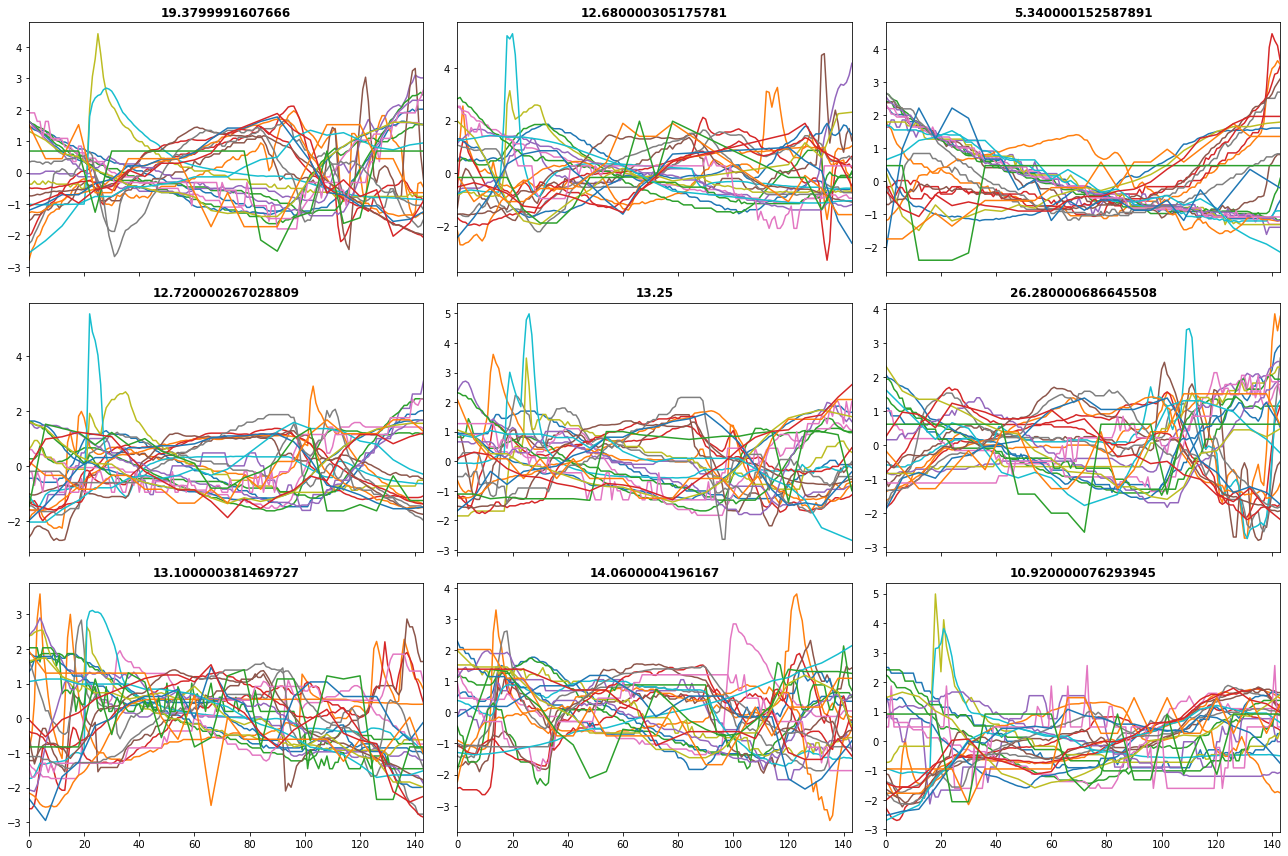

In [9]:
dls.show_batch()

## Build learner 🏗

* Model: we can choose any of the time series models available in `timeseriesAI`. The same ones that work for classification also work for regression. In this case we'll use a state-of-the-art time series model called ` InceptionTime`.
* Loss: since this is a regression problem, we''l use a regression loss (`MSELossFlat`). However, there's not need to pass it to the Learner, as it will automatically infer the required loss.
* Metrics: we'll also choose regression metrics. (`mse` will return the same result as the loss we have selected. Just added it for demo purposes).

SuggestedLRs(valley=0.0008317637839354575)

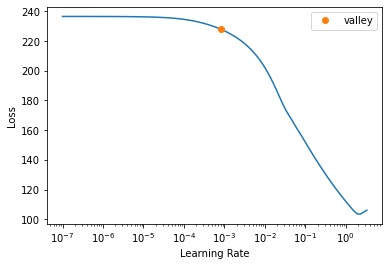

In [10]:
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn.lr_find()

It seems we can use a lr around 1e-2. Let's try it.

In [11]:
learn.loss_func

FlattenedLoss of MSELoss()

## Train model 🚵🏼‍

epoch,train_loss,valid_loss,mae,_rmse,time
0,216.931152,203.547485,13.845869,14.267007,00:02
1,213.819611,203.022141,13.827038,14.248584,00:01
2,210.624527,201.900360,13.786881,14.209165,00:00
3,206.927444,199.716049,13.708891,14.132092,00:00
4,202.685211,193.952164,13.503456,13.926671,00:00
5,197.971634,185.306015,13.194041,13.612715,00:00
6,193.038177,132.944794,11.147423,11.530169,00:00
7,188.072540,105.981087,9.913648,10.294712,00:00
8,182.442841,72.479141,8.135539,8.513468,00:00
9,176.308655,43.024395,6.269855,6.559299,00:00


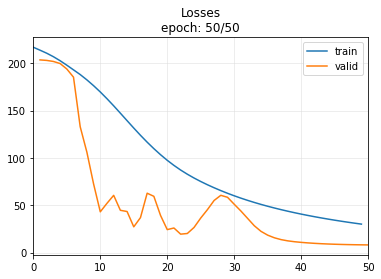

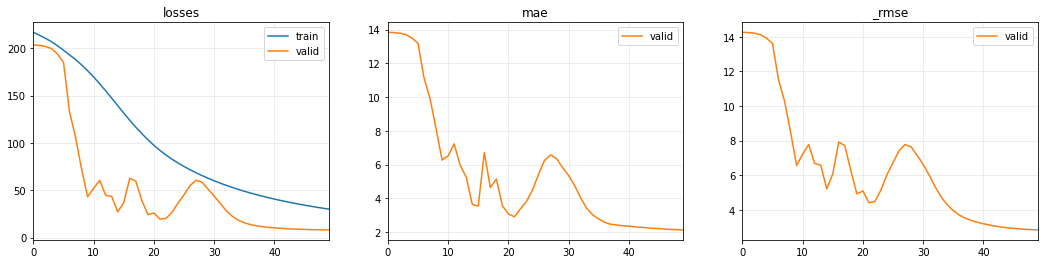

In [12]:
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn.fit_one_cycle(50, 1e-2)

In [13]:
PATH = Path('./models/Regression.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn.export(PATH)

In [14]:
del learn

## Inference ⎘

We'll now upload the saved learner and create the predictions:

In [15]:
PATH = Path('./models/Regression.pkl')
learn = load_learner(PATH, cpu=False)

In [51]:
def evaluate(idx):
    probas, _, preds = learn.get_X_preds(X[splits[idx]])
    print(skm.mean_squared_error(y[splits[idx]], preds, squared=False))
    return probas, preds

In [52]:
probas_tr, preds_tr = evaluate(0)
probas_vl, preds_vl = evaluate(1)

0.6874466004543768


2.8367484721244556


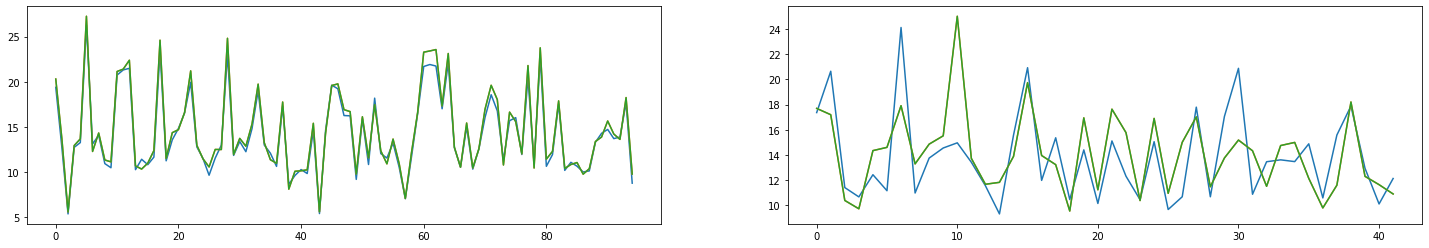

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(y[splits[0]])
ax1.plot(probas_tr)
ax1.plot(preds_tr)
ax2.plot(y[splits[1]])
ax2.plot(probas_vl)
ax2.plot(preds_vl)
fig.set_figwidth(25)
fig.show()

As you can see, this matches the valid rmse at the end of training, so the model is predicting correctly. Now you can pass any data and generate other predictions.

## Summary ✅

As you can see, to use fastai and timeseriesAI to perform a time series regression/ forecasting task is pretty easy. The only thing you need to make sure is that:

* Your data is correctly prepared (with ys as floats)
* Select the right metrics (Learner will automatically select the right loss, unless you want to pass a specific one yourself).